In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import scipy.io as sio
import random
import numpy as np
import import_ipynb
import dataloader_mnist
import networks_mnist
from model import PixelCNN
from torchviz import make_dot
from tqdm import tqdm

importing Jupyter notebook from dataloader_mnist.ipynb
importing Jupyter notebook from networks_mnist.ipynb


In [2]:
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lat_dim = 32

In [3]:
MNIST_PATH = "/home/ziyigong/Datasets/MNIST/%s.pt"
dataset_train = dataloader_mnist.MNIST(mnist_pt_path = MNIST_PATH % 'train')
dataset_test  = dataloader_mnist.MNIST(mnist_pt_path = MNIST_PATH % 'test')
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
enc_mnist = networks_mnist.EncMNIST(lat_dim).to(device)
dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(lat_dim+10, 1)).to(device)

# dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(1,lat_dim,3,6,1)).to(device)

# dec_mnist = networks_mnist.DecMNIST(lat_dim).to(device)

In [20]:
class Vanilla_VAE(nn.Module):
    def __init__(self, encoder, decoder, batch_size=batch_size):
        super(Vanilla_VAE,self).__init__()
        self.batch_size = batch_size
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x):
        param1, param2 = self.encoder(x)
        return param1, param2
    
    def sampling(self, mu, std):
        
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, z,x, label, generate_mode):
        z_cond = torch.cat((z,label),1 )
        x_rec = self.decoder(z_cond, x, generate_mode)
        return x_rec

    
    def loss_function(self,x_rec, x, mu, log_var):
        x_rec = x_rec.flatten(-3,-1)
#         x_rec = x_rec

#         mse_loss = nn.MSELoss(reduction='sum')

#         x = torch.heaviside(x-0.5,torch.tensor([0.0]).to(device))
        # interval is 255/color_level
        color_level = 256
        x = (x * (color_level - 1)).floor().long()
        # print(torch.unique(x))
#         print('x size', x.size())        
#         print('x_rec size', x_rec.size())
#         print('x max',x.max())
#         print('x min',x.min())
#         print('xrec max',x_rec.max())
#         print('xrec min',x_rec.min())

#         x1 = "hello"
        ce_loss = nn.CrossEntropyLoss(reduction='sum')
        MSE = ce_loss(x_rec,x.long())
        # print(MSE)
        # assert x1 == "goodbye"

        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        total_loss = MSE+KLD
        return total_loss, MSE,KLD
    
    def forward(self, x, generate_mode = False):
        # print('img',x.size())
        img = x[:,0:784]
        label = x[:,784:794]
        mu, log_var = self.encode(img)
        std = torch.exp(0.5 * log_var)
        if generate_mode:
#             z = self.sampling(torch.zeros_like(mu), torch.ones_like(std))
            z = self.sampling((mu), (std))
            condition = F.one_hot(torch.tensor(5),num_classes=10).unsqueeze(0)
            condition = condition.repeat(self.batch_size, 1)

            label = condition.to(device)
            x_rec = self.decode(z,torch.zeros_like(img),label, generate_mode)[0]
            # x_rec = torch.exp(x_rec)
            total_loss = 0
            rec_loss = 0 
            kl_loss = 0
        else:
            z = self.sampling(mu, std)

            x_rec = self.decode(z,img,label, generate_mode)[0]
            x_rec = torch.exp(x_rec)
            total_loss, rec_loss,kl_loss = self.loss_function(x_rec, img, mu, log_var)
        results = {'data':x,'x_rec': x_rec,
            'total_loss': total_loss, 'rec_losses': rec_loss, 'KL_loss': kl_loss
        }
        return results


In [6]:
vae = Vanilla_VAE(enc_mnist,dec_mnist, batch_size=batch_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [7]:
def train(model,train_loader,epoch):
    model.train()
    for k, data in (enumerate(train_loader)):
        optimizer.zero_grad()
        results = model(data[0].to(device))
        torch.autograd.set_detect_anomaly(True)
        results['total_loss'].backward() 
        optimizer.step()    
    return results

In [8]:
epoch  = 0
epochs = 2 + epoch
tot_loss_epoch = np.zeros(epochs)
rec_loss_epoch = np.zeros(epochs)
KL_loss_epoch  = np.zeros(epochs)
for epoch in tqdm(range(epoch, epochs)):
    results = train(vae,train_loader,epoch)
    tot_loss_epoch[epoch] = results['total_loss'].cpu()
    rec_loss_epoch[epoch] = results['rec_losses'].cpu()
    KL_loss_epoch[epoch]  = results['KL_loss'].cpu()

100%|███████████████████████████████████████████████████████████████████████████| 2/2 [02:24<00:00, 72.45s/it]


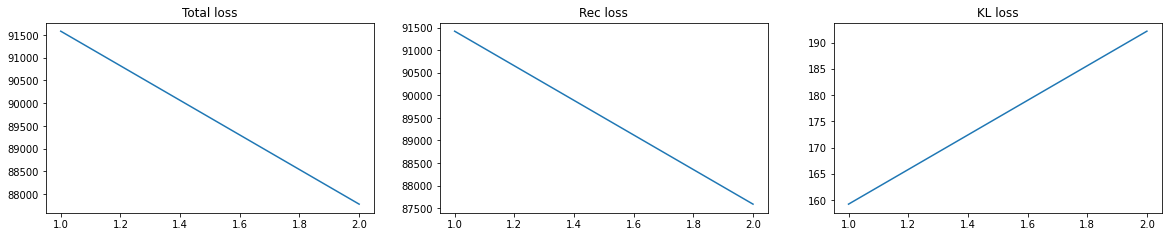

In [9]:
epoch_array = np.linspace(1,epochs,epochs)
fig, axs = plt.subplots(1,3,figsize=(20, 3.5))
axs[0].plot(epoch_array, tot_loss_epoch)
axs[0].set_title('Total loss')
axs[1].plot(epoch_array, rec_loss_epoch)
axs[1].set_title('Rec loss')
axs[2].plot(epoch_array, KL_loss_epoch)
axs[2].set_title('KL loss')
plt.show()

In [10]:
results['x_rec'].max(dim=1).indices.shape

torch.Size([128, 1, 28, 28])

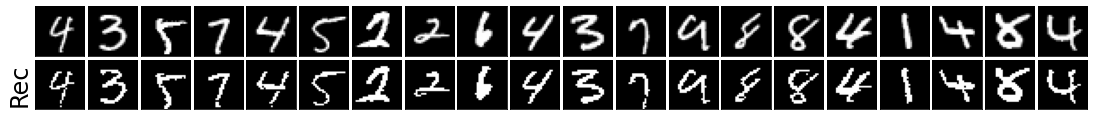

In [11]:
x_rec = results['x_rec'].max(dim=1).indices
# x_rec = results['x_rec']

data  = results['data'][:,0:784]
ncols = min(len(x_rec), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data, x_rec)):
    if i>= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.detach().cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [12]:
## Generation of images
def generate(model,train_loader,generate_mode):
    model.eval()
    for k, data in (enumerate(train_loader)):
        if k>=1:
            break
        results = model(data[0].to(device),generate_mode)
    return results

In [24]:
results_generate = generate(vae_,train_loader,generate_mode= True)

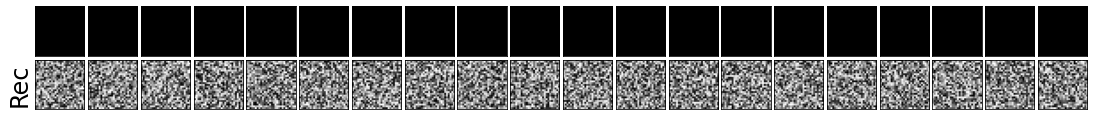

In [25]:
x_rec = results_generate['x_rec']
# x_rec = results_generate['x_rec']

data  = torch.zeros_like(results_generate['data'])[:,0:784]
ncols = min(len(x_rec), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data, x_rec)):
    if i>= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.detach().cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [15]:
import importlib
import model
importlib.reload(model)
from model import PixelCNN

In [23]:
enc_mnist = networks_mnist.EncMNIST(lat_dim).to(device)
dec_mnist = networks_mnist.pixelcnn_decoder(PixelCNN(lat_dim+10, 1)).to(device)
vae_ = Vanilla_VAE(enc_mnist,dec_mnist, batch_size=batch_size).to(device)
vae_.load_state_dict(vae.state_dict())

<All keys matched successfully>